In [52]:
import numpy as np
import pandas as pd
import gc
import time
import pickle

from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, auc
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json
import re
import shap
from shap.maskers import Independent

In [53]:
# Où sont les fichiers à charger
pathProject="/Users/anacoluthedev/Dev/Data/home-credit-default-risk/"

In [54]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# Preprocessing des données
### Repris essentiellement du notebook Kaggle

In [55]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [56]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = True):
    # Read data and merge
    df = pd.read_csv(pathProject+'application_train.csv', nrows= num_rows)
    test_df = pd.read_csv(pathProject+'application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    # df = df.append(test_df).reset_index()
    # code causant l'erreur 'DataFrame' object has no attribute 'append', remplacé, par ces 2 lignes

    df = pd.concat([df, test_df])
    df = df.reset_index(drop=True)
    
    # Categorical features: Binary features and One-Hot encoding
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    del test_df
    gc.collect()
    return df

In [57]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv(pathProject+'bureau.csv', nrows = num_rows)
    bb = pd.read_csv(pathProject+'bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(columns= 'SK_ID_BUREAU', inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'DAYS_CREDIT_UPDATE': ['min', 'max', 'mean'],
        'AMT_ANNUITY': ['max', 'mean'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACT_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLS_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [58]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv(pathProject+'previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APR_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REF_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [59]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv(pathProject+'POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [60]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv(pathProject+'bureau.csv', nrows = num_rows)
    bb = pd.read_csv(pathProject+'bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

   #df["NOM COLONNE"] = pd.to_numeric(df['NOM COLONNE'])


    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(columns= 'SK_ID_BUREAU', inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'DAYS_CREDIT_UPDATE': ['min', 'max', 'mean'],
        'AMT_ANNUITY': ['max', 'mean'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACT_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLS_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [61]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv(pathProject+'installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INS_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INS_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [62]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv(pathProject+'credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(columns = ['SK_ID_PREV'], inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc

    gc.collect()
    return cc_agg

### La fonction du modèle de prédiction Kaggle est trop longue, son appel est mis en commentaire / désactivé ci-dessous

In [63]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1 )

        # Early stopping parameters
        early_stopping_rounds = 10
        best_auc = 0
        best_iteration = 0
        no_improvement = 0



        # Manually implementing early stopping
        for i in range(10000):  # assuming max iterations as 10000
            # Perform one iteration of training
            clf.n_estimators = i + 1
            clf.fit(train_x, train_y, eval_set=[(valid_x, valid_y)])

            # Evaluate AUC on validation set
            valid_pred = clf.predict_proba(valid_x)[:, 1]
            current_auc = roc_auc_score(valid_y, valid_pred)

            # Check for improvement
            if current_auc > best_auc:
                best_auc = current_auc
                best_iteration = i + 1
                no_improvement = 0
            else:
                no_improvement += 1

            # Break the loop if no improvement in 'early_stopping_rounds' iterations
            if no_improvement >= early_stopping_rounds:
                print(f"Early stopping: Stopping training at iteration {i+1}")
            break

        # Refit the model with the best iteration
        clf.n_estimators = best_iteration
        clf.fit(train_x, train_y, eval_set=[(valid_x, valid_y)])


        model = clf.fit(train_x, train_y, eval_set=[(valid_x, valid_y)])

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc')

        # Erreur avec Early stopping
        #clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
        #    eval_metric= 'auc', early_stopping_rounds= 100)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    test_df['TARGET'] = sub_preds
    test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    #return feature_importance_df
    return oof_preds, model 


In [64]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')

### Fonctions supplémentaires ajoutées, pour traiter les valeurs infinies ou non std

In [65]:
# Preprocessing remplaçant les valeurs infinies par NaN et supprimant les colonnes non numériques
def clean_infinite_and_nonNum(df):
    print("Number of infinite values in the dataframe :", np.isinf(df).values.sum())
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    print("Are there any infinite values left?:", np.isinf(df).values.any())

    # Identification des colonnes dont le type n'est pas numérique, afin de les supprimer pour les calculs SHAP ultérieurs
    non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns
    print("Non-numeric columns:", non_numeric_columns)

    df = df.drop(columns=non_numeric_columns)

    non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns
    print("Still non-numeric columns, after cleaning:", non_numeric_columns.any())
    return df

In [66]:
# Résolution erreur LightGBMError: Do not support special JSON characters in feature name.

def clean_JSON(df):
    regex = r'[^a-zA-Z0-9\s]'
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].str.replace(regex, '', regex=True)
    return df

In [67]:
def clean_feature_name(name):
    # Remplacement des caractères JSON avec un underscore
    return re.sub(r'[{}\[\]:;,<>/?\\|`~!@#$%^&*()\-+=\'"]', '_', name)

In [68]:
def clean_all(df):
    df = clean_infinite_and_nonNum(df)
    df = clean_JSON(df)

    # Génération de nom de colonnes sans caractères spéciaux
    cleaned_column_names = [clean_feature_name(name) for name in df.columns]
    # Mise à jout des noms de colonnes du dataframe
    df.columns = cleaned_column_names   
    print("JSON characters cleaned")
    df.columns = [col.replace(' ', '_') for col in df.columns]

    return df

In [69]:
def drop_emptyTARGETs(df):
    # Suppression des lignes TARGET dépourvues de valeur
    df_copy = df.copy()
    n = df_copy.loc[:,'TARGET'].shape[0]
    df_copy.dropna(subset=['TARGET'], inplace=True)
    m = df_copy.loc[:,'TARGET'].shape[0]
    print("Total number of lines before:", n, "Number of lines with the TARGET filled-in:", m)
    return df_copy

### Fonction d'affichage de la ROC ou AUC (Area Under the ROC Curve)

In [70]:
def graphROC(y_true, y_pred_probs, modelName):
    # Calcul de la courbe ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)

    # Calcul de l'AUC (Area Under the ROC Curve)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve '+modelName)
    plt.legend(loc='lower right')

### Pré-traitements de l'ensemble des dataframes source, dans un seul, global, appelé df 

In [71]:
submission_file_name = "submission_kernel26.csv"
num_rows = None
df = application_train_test(num_rows)
with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
#with timer("Process credit card balance"):
#        cc = credit_card_balance(num_rows)
#        print("Credit card balance df shape:", cc.shape)
#        df = df.join(cc, how='left', on='SK_ID_CURR')
#        del cc
#        gc.collect()
        
df = clean_all(df)

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 122)
Process bureau and bureau_balance - done in 24s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 30s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 15s
Installments payments df shape: (339587, 26)
Process installments payments - done in 38s
Number of infinite values in the dataframe : 61


KeyboardInterrupt: 

In [ ]:
df = drop_emptyTARGETs(df)

Total number of lines before: 356255 Number of lines with the TARGET filled-in: 307511


# Analyse exploratoire

<Axes: ylabel='Frequency'>

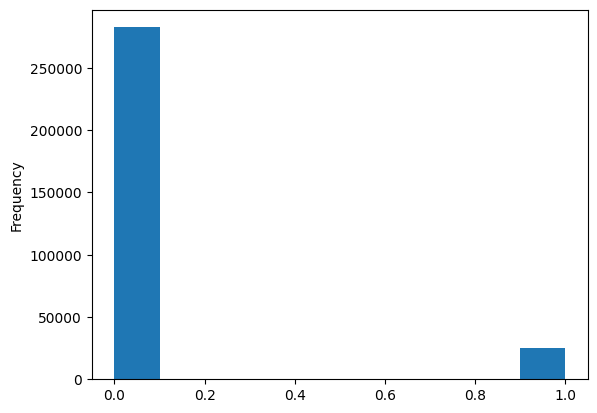

In [ ]:
df['TARGET'].astype(int).plot.hist()

Ratio of the repayed credit is 92 %


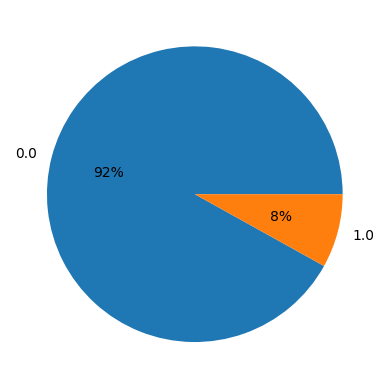

In [ ]:
nRepayed = df.loc[(df['TARGET']==0),:].shape[0]
nDefaulted = df.loc[(df['TARGET']==1),:].shape[0]
ratioDefault = nDefaulted / (nRepayed + nDefaulted)

# Calcul du ratio de défault, et du percentile à afficher
percentThreshold = 100 - int(ratioDefault * 100)
print('Ratio of the repayed credit is',percentThreshold,'%')

TargetCredit = df.TARGET.value_counts()
palette_color=sns.color_palette()
plt.pie(TargetCredit,labels=TargetCredit.index,colors=palette_color,autopct='%.0f%%')
plt.show()

### Identification des features qui seraient trop corrélées à la Target

In [ ]:
# Fraction du dataset utilisée dans les calculs de corrélation
p = 100
n=int(df.shape[0]/p)
correlations = df.sample(n).corr()

target_correlation = correlations['TARGET'].drop('TARGET', axis=0)

# Elimination des corrélations qui ne sont pas significatives
significant_correlations = target_correlation[abs(target_correlation) > 0.05]
sorted_correlations = significant_correlations.sort_values(ascending=False)

print(sorted_correlations)

PREV_NAME_CONTRACT_STATUS_Refused_MEAN       0.105055
BURO_STATUS_1_MEAN_MEAN                      0.093153
REF_DAYS_DECISION_MIN                        0.088686
PREV_PRODUCT_COMBINATION_Card_Street_MEAN    0.088583
ACT_AMT_CREDIT_SUM_OVERDUE_MEAN              0.087091
                                               ...   
PREV_CODE_REJECT_REASON_XAP_MEAN            -0.110283
REF_RATE_DOWN_PAYMENT_MAX                   -0.115864
EXT_SOURCE_3                                -0.146185
EXT_SOURCE_1                                -0.164597
EXT_SOURCE_2                                -0.166139
Name: TARGET, Length: 99, dtype: float64


# Fonctions de prédiction

### Utilisation de la fonction fournie par le notebook Kaggle, très légèrement modifiée
##### finalement écartée car beaucoup trop longue à exécuter

In [ ]:
'''with timer("Run LightGBM with kfold"):
    oof_preds, model = kfold_lightgbm(df, num_folds= 5, stratified = False)
'''

'with timer("Run LightGBM with kfold"):\n    oof_preds, model = kfold_lightgbm(df, num_folds= 5, stratified = False)\n'

## Utilisation d'un LightGBM simple 
#### entrainé avec la librairie lightgbm, train, très rapide

In [ ]:

def simpleLGBM(df):
    # Définition de X_train et de y_train
    train_df = df.copy()
    y = train_df['TARGET']
    X = train_df.drop(columns= ['TARGET'], axis = 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Conversion des données en dataset intelligible pour LightGBM
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

    # Utilisation des paramètres précédents (fournis dans le notbook Kaggle)
    params = {
    'boosting_type': 'gbdt',   # Gradient boosting decision tree
    'objective': 'binary',     # Binary target feature
    'metric': 'binary_logloss',# Metric for binary classification
    'num_leaves': 31,          # Number of leaves in one tree
    'learning_rate': 0.05,     # How much to update the model in each iteration
    'feature_fraction': 0.9,   # The fraction of features to consider in each tree
    'bagging_fraction': 0.8,   # The fraction of data to consider in each iteration
    'bagging_freq': 5,         # Frequency for bagging
    'verbose': 0               # Controls the level of LightGBM's verbosity
    }


    model = lgb.train(params,
                train_data,
                num_boost_round=100,      # Number of boosting iterations
                valid_sets=[train_data, test_data],  # Validation data
                ) # Will stop if no improvement is shown in the given rounds

    # Prédictions avec le modèle fité
    y_pred = model.predict(X, num_iteration=model.best_iteration)
    aucC = roc_auc_score(y, y_pred)
    print(f"The AUC score is: {aucC}")

    # Calculons la valeur au percentile à partir duquel nous observons des défauts, afin de calculer le seuil pour rendre boléennes nos estimations
    valPercentileDefault = np.percentile(y_pred,percentThreshold)

    print('The value above with the credit is most likely to be defaulted is %.6f' % valPercentileDefault)

    #score1 = business_score(y, y_pred)
    #print(f"The business score is: {score1}")
    #graphROC(df['TARGET'].values, y_pred, "LightGBM")
    graphROC(y, y_pred, "LightGBM")

    return y_pred, model, X, y

In [ ]:
def simpleLGBMfit(df):
    # Définition de X_train et de y_train
    train_df = df.copy()
    y = train_df['TARGET']
    X = train_df.drop(columns= ['TARGET'], axis = 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Conversion des données en dataset intelligible pour LightGBM
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)


    model = lgb.LGBMClassifier(objective='binary', 
                         verbose=-1, 
                         learning_rate=0.1, 
                         n_estimators=1000)

    model.fit(X_train, y_train)

    # Prédictions avec le modèle fité
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]
    aucC = roc_auc_score(y, y_pred_proba)
    print(f"The AUC score is: {aucC}")

    # Calculons la valeur au percentile à partir duquel nous observons des défauts, afin de calculer le seuil pour rendre boléennes nos estimations
    valPercentileDefault = np.percentile(y_pred_proba,percentThreshold)

    print('The value above with the credit is most likely to be defaulted is %.6f' % valPercentileDefault)

    #score1 = business_score(y, y_pred)
    #print(f"The business score is: {score1}")
    #graphROC(df['TARGET'].values, y_pred, "LightGBM")

    graphROC(y, y_pred_proba, "LightGBM")

    return y_pred, y_pred_proba, model, X, y

In [ ]:
def simpleRF(df):
    # Définition de X_train et de y_train
    X = df.drop('TARGET', axis=1)
    y = df['TARGET']


    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

    rf_model = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    y_prob = rf_model.predict_proba(X_test)[:, 1]
    aucC = roc_auc_score(y_test, y_prob)
    print(f"The AUC score is: {aucC}")

    #score1 = business_score(y, y_pred)
    #print(f"The business score is: {score1}")
    graphROC(y_test, y_prob, "RandomForest")

    return y_pred, y_prob, rf_model, X, y

The AUC score is: 0.7950852614759097
The value above with the credit is most likely to be defaulted is 0.195335


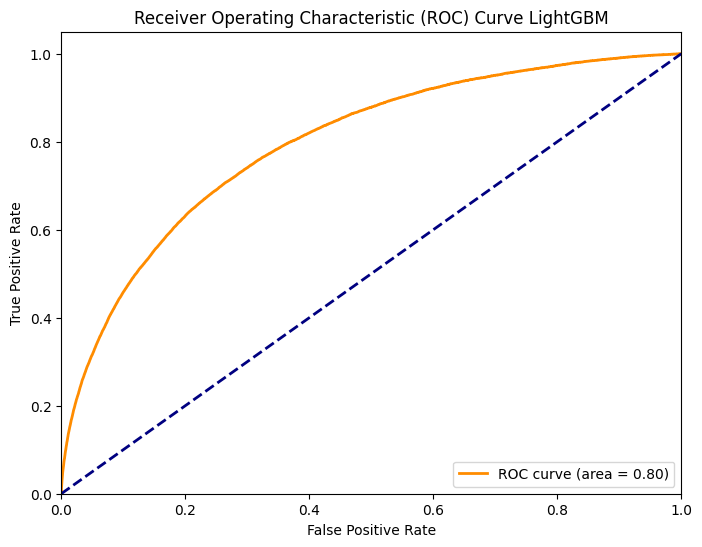

In [ ]:
y_pred, model, X, y = simpleLGBM(df)

In [ ]:
#y_pred, y_pred_proba, model, X, y = simpleLGBMfit(df)

In [ ]:
# Calculons la valeur au percentile à partir duquel nous observons des défauts, afin de calculer le seuil pour rendre boléennes nos estimations
valPercentileDefault = np.percentile(y_pred,percentThreshold)

print('The value above with the credit is most likely to be defaulted is %.6f' % valPercentileDefault)

The value above with the credit is most likely to be defaulted is 0.195335


In [ ]:
'''with timer("Compute Shap values for LightGBM"):
    background = Independent(data=df)
    explainer = shap.Explainer(model, background)

    X = df.drop('TARGET', axis=1)
    y = df['TARGET']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.99, random_state=42)

    # Create the SHAP TreeExplainer using your pre-trained LightGBM model
    explainer = shap.TreeExplainer(model, data=X_val, model_output="raw")

    # Calculate SHAP values for your validation set or any subset you're interested in
    # Include the 'check_additivity=False' option
    shap_values = explainer.shap_values(X_val, check_additivity=False)

    # Summary plot of SHAP values for the features across all data points in the subset
    shap.summary_plot(shap_values, X_val, plot_type="bar")

    # For detailed visualization of individual predictions
    # shap.plots.waterfall, shap.plots.force, etc., can be used
    # Example for the first instance in the validation set
    shap.plots.waterfall(shap_values[0], X_val.iloc[0])
    
    # Summarize the SHAP values across all features to get a measure of overall feature importance
    shap_sum = np.abs(shap_values).mean(axis=0)  # Use [1] for binary classification, adjust accordingly

    # Selection des 20 features les plus importantes, pour les utiliser par la suite, pour d'autres modèles
    importance_df = pd.DataFrame([X_train.columns.tolist(), shap_sum.tolist()]).T
    importance_df.columns = ['Feature', 'Importance']
    importance_df = importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)
'''

'with timer("Compute Shap values for LightGBM"):\n    background = Independent(data=df)\n    explainer = shap.Explainer(model, background)\n\n    X = df.drop(\'TARGET\', axis=1)\n    y = df[\'TARGET\']\n    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.99, random_state=42)\n\n    # Create the SHAP TreeExplainer using your pre-trained LightGBM model\n    explainer = shap.TreeExplainer(model, data=X_val, model_output="raw")\n\n    # Calculate SHAP values for your validation set or any subset you\'re interested in\n    # Include the \'check_additivity=False\' option\n    shap_values = explainer.shap_values(X_val, check_additivity=False)\n\n    # Summary plot of SHAP values for the features across all data points in the subset\n    shap.summary_plot(shap_values, X_val, plot_type="bar")\n\n    # For detailed visualization of individual predictions\n    # shap.plots.waterfall, shap.plots.force, etc., can be used\n    # Example for the first instance in the validation se

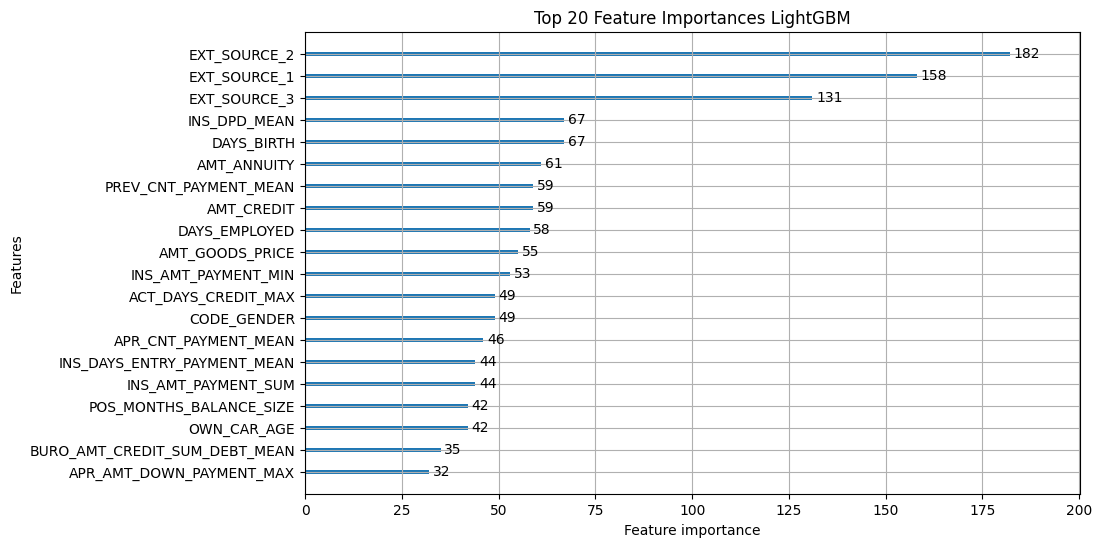

In [ ]:
importances = model.feature_importance(importance_type='split')

# Conversion en pandas DataFrame
feature_names = X.columns
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Tri par ordre d'importance, des 20 plus importantes
top_20_features = feature_importances.sort_values(by='importance', ascending=False).head(20)

# Affichage
lgb.plot_importance(model, max_num_features=20, importance_type='split', figsize=(10, 6))
plt.title('Top 20 Feature Importances LightGBM')
plt.show()

The AUC score is: 0.7105916837222572


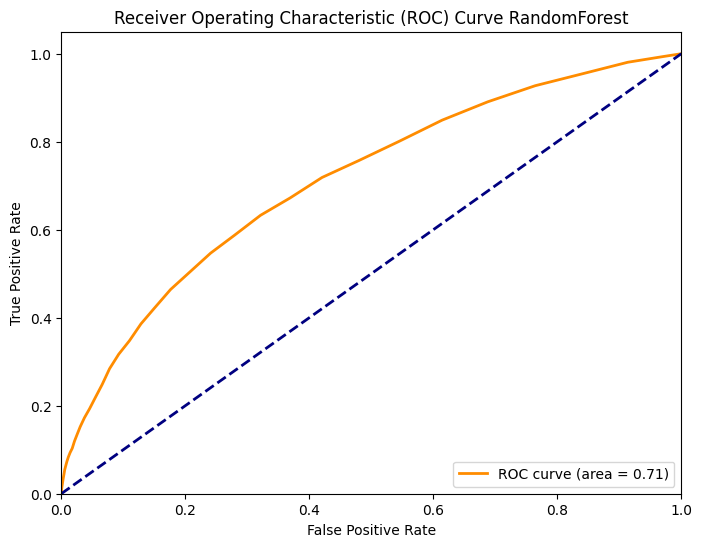

In [34]:
y_predRF, y_probaRF, modelRF, XRF, yRF = simpleRF(df)

### Distribution des probabilités de défault calculées par le modèle 

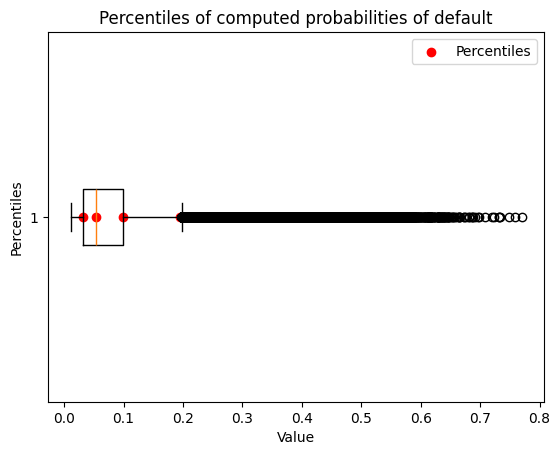

In [35]:
percentiles = np.percentile(y_pred, [25, 50, 75, percentThreshold])

plt.boxplot(y_pred, vert=False)
plt.scatter(percentiles, [1, 1, 1, 1], color='red', marker='o', label='Percentiles')
plt.xlabel('Value')
plt.ylabel('Percentiles')
plt.title('Percentiles of computed probabilities of default')
plt.legend()
plt.show()

### Simplification du dataset pour ne conserver que les features les plus importantes, et la Target

In [36]:

important_features = top_20_features['feature'].tolist()
important_features.append('TARGET')

print('Dataset size before the elimination of the non relevant features:', df.shape)

df_filtered = df[important_features]
print('Dataset size after', df_filtered.shape)


Dataset size before the elimination of the non relevant features: (307511, 528)
Dataset size after (307511, 21)


### Test des performances du modèle limité aux 20 features les plus importantes, pour l'accélérer

The AUC score is: 0.7814712737790216
The value above with the credit is most likely to be defaulted is 0.196866


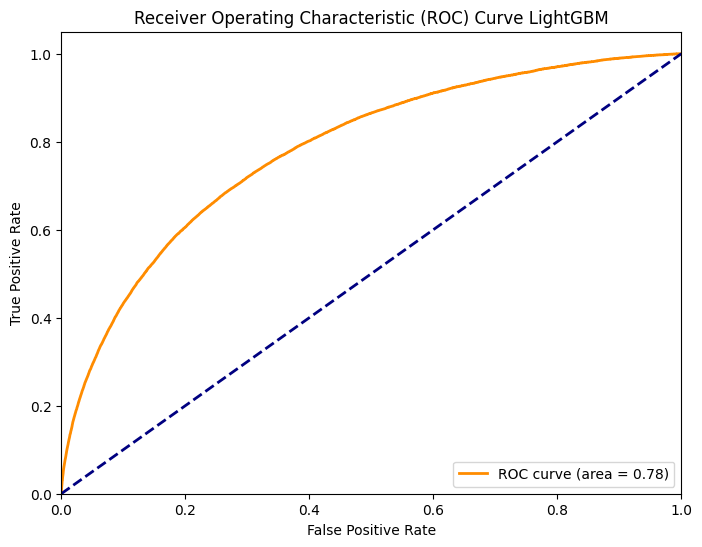

In [37]:
y_pred, model, X, y = simpleLGBM(df_filtered)

## Calcul d'un score Business, plus adapté à notre cas concret, 
#### et sa mesure en fontion du seuil de conversion de probabilité de défaut, en booléen défaut

In [38]:
# Calcul du Business Score: un crédit accordé qui ne sera pas remboursé est très pénalisant (faux négatif), perte en principal
# contrairement à un crédit refusé qui aurait été remboursé (faux positif) que l'on surpondère dans le calcul
# Ce Business score est ainsi une fonction de cout que l'on cherche à minimiser i.e. minimiser le manque à gagner
def customBusinessScore(tp, tn, fp, fn):
    businessScore = fp  + fn * 10
    return businessScore

In [39]:
# Fonction de calcul de score, utilisable par GridSearchCV, 
# prenant 2 paramètres : les valeurs vraies et celles prédites
# retournant un Business Score

def business_score(y_true, y_pred):
    
    # Conversion des probabilités en valeurs booléennes avec notre seuil calculé juste avant
    binary_predictions = np.where(y_pred > valPercentileDefault, 1, 0)
    
    # Calcul de la matrice de confusion
    conf_matrix = confusion_matrix(y_true, binary_predictions)

    # Extraction des résultats
    tn, fp, fn, tp = conf_matrix.ravel()
    score = customBusinessScore(tp, tn, fp, fn)
    print ('Current Business Score:',score)
    return score


In [40]:
# Définition d'une fonction scorer utilisable par GridSearchCV
business_scorer = make_scorer(business_score, greater_is_better=False,needs_proba=True)

## Modèles naifs mesurant la qualité de notre LightGBM

In [41]:
def testDummyC(df):
    # Separation des Targets, des features
    X = df.drop(columns=['TARGET'])  
    y = df['TARGET']  

    imputer = SimpleImputer(strategy="mean")
    X_imputed = imputer.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)


    # DummyClassifier pour la classification
    dummy_clf = DummyClassifier(strategy="most_frequent")
    dummy_clf.fit(X_train, y_train)
    y_pred_probs = dummy_clf.predict_proba(X_test)[:, 1]  # Probabilités de la bonne classe

    graphROC(y_test, y_pred_probs, "DummyRegressor")

In [42]:
def testLogisticR(df):
    # Separation des Targets, des features
    X = df.drop(columns=['TARGET'])  
    y = df['TARGET']  

    imputer = SimpleImputer(strategy="mean")
    X_imputed = imputer.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

    log_reg = LogisticRegression(max_iter=1000)  # Increase max_iter if needed for convergence
    log_reg.fit(X_train, y_train)

    # Predicting probabilities for the test set
    y_pred_probs = log_reg.predict_proba(X_test)[:, 1]

    graphROC(y_test, y_pred_probs, 'LogisticRegression')

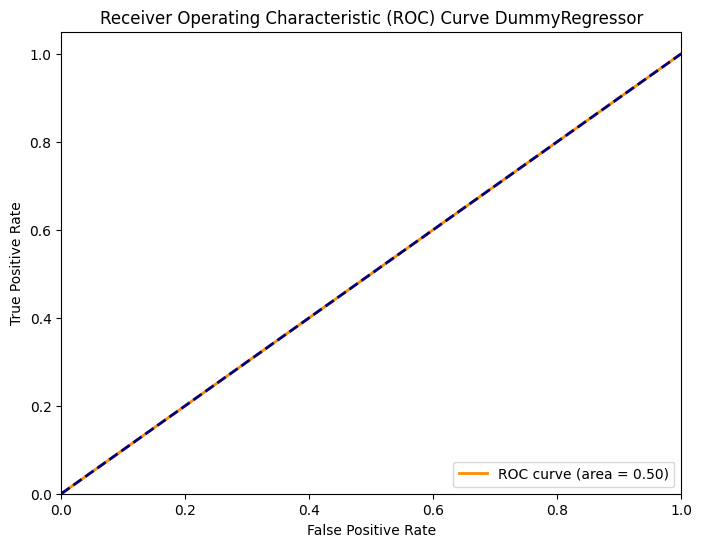

In [43]:
testDummyC(df)

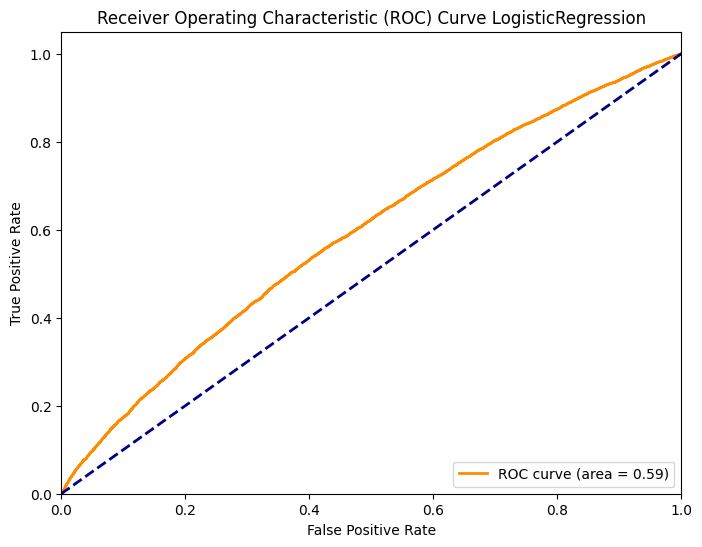

In [44]:
testLogisticR(df)

In [ ]:
'''
# Problème de convergence, avec GridSearchCV, même si le score est correctement calculé - temps de calcul ?
# Préparation du dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = lgb.LGBMClassifier()

# Définition des paramètres à rechercher
param_grid = {
    'num_leaves': [34],
    'learning_rate': [0.5],
    'n_estimators': [1000],
}




# Initialisation GridSearchCV
grid_search = GridSearchCV(model, param_grid, scoring=business_scorer, cv=5, verbose=1)

# Fit
grid_search.fit(X_train, y_train)

# Meilleurs paramètres et meilleur score
print("Best parameters found: ", grid_search.best_params_)
print("Best business score found: ", grid_search.best_score_)
'''

'\n# Problème de convergence, avec GridSearchCV, même si le score est correctement calculé - temps de calcul ?\n# Préparation du dataset\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\nmodel = lgb.LGBMClassifier()\n\n# Définition des paramètres à rechercher\nparam_grid = {\n    \'num_leaves\': [34],\n    \'learning_rate\': [0.5],\n    \'n_estimators\': [1000],\n}\n\n\n\n\n# Initialisation GridSearchCV\ngrid_search = GridSearchCV(model, param_grid, scoring=business_scorer, cv=5, verbose=1)\n\n# Fit\ngrid_search.fit(X_train, y_train)\n\n# Meilleurs paramètres et meilleur score\nprint("Best parameters found: ", grid_search.best_params_)\nprint("Best business score found: ", grid_search.best_score_)\n'

## Fonction de prédiction LightGBM avec recherche des meilleurs hyperparamètres, 
#### choisis d'après le Business Score (minimisé)

In [48]:
# Mise en oeuvre d'un GridSearch, spécifique à l'aide d'un early stopping dédié
def lightGBMGrid(X_train, X_test, y_train, y_test, param_grid, modelNameX, smoteT):

    # Initialisation à +infini, du business score, qui est un cout à minimiser
    best_cost = float('inf')
    best_params = None
    cost_improvement_threshold = 0.002  # Proportion minimale de l'amélioration nécessaire pour continuer à rechercher les meilleurs paramètres
    last_cost = float('inf')

    # Setup K-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    print('Sets of hyperparameters to be tested:', param_grid)
    if smoteT:
        print('Training with SMOTE')
        # 92% des crédits sont remboursés, les données sont très déséquilibrées
        # Utilisons SMOTE (Synthetic Minority Over-sampling Technique) pour corriger le déséquilibre du dataset
        # en créant de nouvelles données synthétiques en interpolant des examples
        smote = SMOTE(random_state=42)

        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

        # Conversion de X_train_smote en dataframe
        X_train_smote_df = pd.DataFrame(X_train_smote, columns=X.columns)
        X_train = X_train_smote_df
        y_train = y_train_smote

        #cost_improvement_threshold = 1000

    for params in ParameterGrid(param_grid):
        costs = []
        auc_scores = []
        print('Training with the following parameters:', params)
    
        for train_index, val_index in kf.split(X_train):
            #print("Number of train indexes:", train_index.shape[0])  
            X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        
            # Création des datasets lightGBM
            lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
            lgb_val = lgb.Dataset(X_val_fold, y_val_fold, reference=lgb_train)
        
            # Entrainement des modèles sans les stopping rounds
            model = lgb.train(params,
                                lgb_train,
                                num_boost_round=10000, 
                                valid_sets=[lgb_val])
        
            # Predict du fold
            y_pred = model.predict(X_val_fold, num_iteration=model.best_iteration)
        
            # Calcul du business score (fonction cout que l'on cherche à minimiser)
            cost = business_score(y_val_fold, y_pred)
            costs.append(cost)

            auc_score = roc_auc_score(y_val_fold, y_pred)
            auc_scores.append(auc_score)
    
        # Calcul de la moyenne des couts de l'ensemble des folds
        avg_cost = np.mean(costs)
        mean_test_AUC = np.mean(auc_scores)
        print("Average business score:", avg_cost)
        # print("Average AUC:", mean_test_AUC)
        print("________________________________")
    
        if avg_cost < best_cost:
            best_cost = avg_cost
            best_params = params
            if last_cost < float('inf'):
                improvement = (last_cost - avg_cost) / last_cost
                print("Current improvements:", improvement)
                if improvement < cost_improvement_threshold:
                    print("Stopping search due to insufficient cost improvement.")
                    break
            else:
                last_cost = avg_cost
        else:
            improvement = (last_cost - avg_cost) / last_cost
            print("Current improvements:", improvement)
            if improvement < cost_improvement_threshold:
                print("Stopping search due to insufficient cost improvement.")
                break

        last_cost = avg_cost

    print(f"Best parameters: {best_params}")
    print(f"Lowest average cost: {best_cost}")
    oof_preds = model.predict(X_test)
    graphROC(y_test, oof_preds, modelNameX)
    return model

In [ ]:
'''
param_grid = {
    'verbose': [-1],
    'learning_rate': [0.1],         # Taux d'apprentissage
    'reg_lambda': [0, 0.5],
    'num_leaves': [34],

}
'''

"\nparam_grid = {\n    'verbose': [-1],\n    'learning_rate': [0.1],         # Taux d'apprentissage\n    'reg_lambda': [0, 0.5],\n    'num_leaves': [34],\n\n}\n"

In [50]:
            
param_grid = {
            'verbose': [-1],
            'nthread': [4],
            'n_estimators': [2000, 10000],
            'learning_rate': [0.01, 0.02, 0.05],
            'num_leaves': [10, 34],
            'colsample_bytree': [0.9497036],
            'subsample': [0.8715623],
            'max_depth': [4, 8, 16],
            'reg_alpha': [0.041545473],
            'reg_lambda': [0.0735294],
            'min_split_gain': [0.0222415],
            'min_child_weight': [39.3259775],
           }

In [91]:
'''param_grid = {
    'boosting_type': ['gbdt'],    # Gradient boosting decision tree
    'objective': ['binary'],      # Binary target feature
    'metric': ['binary_logloss'], # Metric for binary classification
    'num_leaves': [31, 50, 70],           # Number of leaves in one tree
    'max_depth': [3, 5, 7],
    'learning_rate': [0.02, 0.05],      # How much to update the model in each iteration
    'n_estimators': [100, 200, 500],
    'feature_fraction': [1],    # The fraction of features to consider in each tree
    'bagging_fraction': [0.8],    # The fraction of data to consider in each iteration
    'bagging_freq': [5],          # Frequency for bagging
    'verbose': [0],               # Controls the level of LightGBM's verbosity
    }
'''

"param_grid = {\n    'boosting_type': ['gbdt'],    # Gradient boosting decision tree\n    'objective': ['binary'],      # Binary target feature\n    'metric': ['binary_logloss'], # Metric for binary classification\n    'num_leaves': [31, 50, 70],           # Number of leaves in one tree\n    'max_depth': [3, 5, 7],\n    'learning_rate': [0.02, 0.05],      # How much to update the model in each iteration\n    'n_estimators': [100, 200, 500],\n    'feature_fraction': [1],    # The fraction of features to consider in each tree\n    'bagging_fraction': [0.8],    # The fraction of data to consider in each iteration\n    'bagging_freq': [5],          # Frequency for bagging\n    'verbose': [0],               # Controls the level of LightGBM's verbosity\n    }\n"

Sets of hyperparameters to be tested: {'verbose': [-1], 'nthread': [4], 'n_estimators': [2000, 10000], 'learning_rate': [0.01, 0.02, 0.05], 'num_leaves': [10, 34, 70], 'colsample_bytree': [0.9497036], 'subsample': [0.8715623], 'max_depth': [4, 8, 16], 'reg_alpha': [0.041545473], 'reg_lambda': [0.0735294], 'min_split_gain': [0.0222415], 'min_child_weight': [39.3259775]}
Training with the following parameters: {'colsample_bytree': 0.9497036, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 39.3259775, 'min_split_gain': 0.0222415, 'n_estimators': 2000, 'nthread': 4, 'num_leaves': 10, 'reg_alpha': 0.041545473, 'reg_lambda': 0.0735294, 'subsample': 0.8715623, 'verbose': -1}


Found `n_estimators` in params. Will use it instead of argument


Current Business Score: 31051


Found `n_estimators` in params. Will use it instead of argument


Current Business Score: 30324


Found `n_estimators` in params. Will use it instead of argument


Current Business Score: 30652


Found `n_estimators` in params. Will use it instead of argument


Current Business Score: 29593


Found `n_estimators` in params. Will use it instead of argument


Current Business Score: 30114
Average business score: 30346.8
________________________________
Training with the following parameters: {'colsample_bytree': 0.9497036, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 39.3259775, 'min_split_gain': 0.0222415, 'n_estimators': 2000, 'nthread': 4, 'num_leaves': 34, 'reg_alpha': 0.041545473, 'reg_lambda': 0.0735294, 'subsample': 0.8715623, 'verbose': -1}


Found `n_estimators` in params. Will use it instead of argument


Current Business Score: 30989


Found `n_estimators` in params. Will use it instead of argument


Current Business Score: 30137


Found `n_estimators` in params. Will use it instead of argument


Current Business Score: 30494


Found `n_estimators` in params. Will use it instead of argument


Current Business Score: 29612


Found `n_estimators` in params. Will use it instead of argument


Current Business Score: 30187
Average business score: 30283.8
________________________________
Current improvements: 0.0020760014235438333
Training with the following parameters: {'colsample_bytree': 0.9497036, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 39.3259775, 'min_split_gain': 0.0222415, 'n_estimators': 2000, 'nthread': 4, 'num_leaves': 70, 'reg_alpha': 0.041545473, 'reg_lambda': 0.0735294, 'subsample': 0.8715623, 'verbose': -1}


Found `n_estimators` in params. Will use it instead of argument


Current Business Score: 30989


Found `n_estimators` in params. Will use it instead of argument


Current Business Score: 30137


Found `n_estimators` in params. Will use it instead of argument


Current Business Score: 30494


Found `n_estimators` in params. Will use it instead of argument


Current Business Score: 29612


Found `n_estimators` in params. Will use it instead of argument


Current Business Score: 30187
Average business score: 30283.8
________________________________
Current improvements: 0.0
Stopping search due to insufficient cost improvement.
Best parameters: {'colsample_bytree': 0.9497036, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 39.3259775, 'min_split_gain': 0.0222415, 'n_estimators': 2000, 'nthread': 4, 'num_leaves': 34, 'reg_alpha': 0.041545473, 'reg_lambda': 0.0735294, 'subsample': 0.8715623, 'verbose': -1}
Lowest average cost: 30283.8


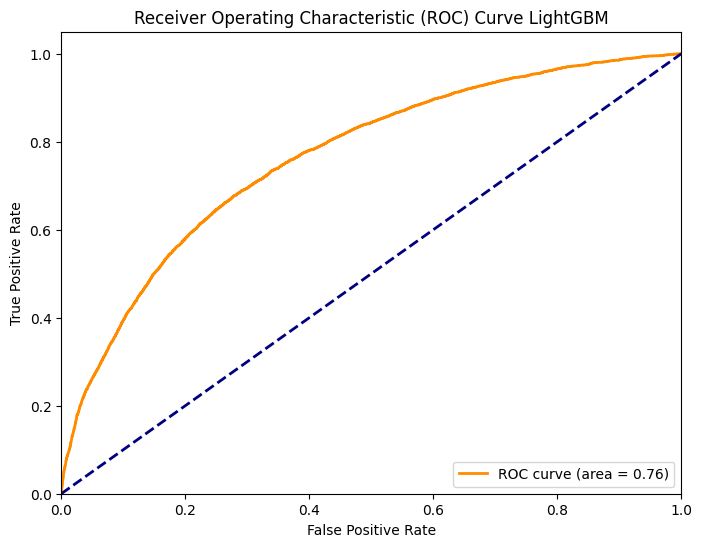

In [49]:
# Définition de X_train et de y_train
train_df = df_filtered[df_filtered['TARGET'].notnull()].copy()
y = train_df['TARGET']
X = train_df.drop(columns= ['TARGET'], axis = 1)
X.columns = [col.replace(' ', '_') for col in X.columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = lightGBMGrid(X_train, X_test, y_train, y_test, param_grid, 'LightGBM', False)

### Nouvel entrainement en corrigeant le déséquilibre des données (peu de défauts)

In [51]:
# Définition de X_train et de y_train
train_df = df_filtered[df_filtered['TARGET'].notnull()].copy()
y = train_df['TARGET']
X = train_df.drop(columns= ['TARGET'], axis = 1)

X.columns = [col.replace(' ', '_') for col in X.columns]

imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = lightGBMGrid(X_train, X_test, y_train, y_test, param_grid, 'LightGBM', True)


Sets of hyperparameters to be tested: {'verbose': [-1], 'nthread': [4], 'n_estimators': [2000, 10000], 'learning_rate': [0.01, 0.02, 0.05], 'num_leaves': [10, 34], 'colsample_bytree': [0.9497036], 'subsample': [0.8715623], 'max_depth': [4, 8, 16], 'reg_alpha': [0.041545473], 'reg_lambda': [0.0735294], 'min_split_gain': [0.0222415], 'min_child_weight': [39.3259775]}
Training with SMOTE
Training with the following parameters: {'colsample_bytree': 0.9497036, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 39.3259775, 'min_split_gain': 0.0222415, 'n_estimators': 2000, 'nthread': 4, 'num_leaves': 10, 'reg_alpha': 0.041545473, 'reg_lambda': 0.0735294, 'subsample': 0.8715623, 'verbose': -1}


Found `n_estimators` in params. Will use it instead of argument


Current Business Score: 32336


Found `n_estimators` in params. Will use it instead of argument


Current Business Score: 32450


Found `n_estimators` in params. Will use it instead of argument


Current Business Score: 31621


Found `n_estimators` in params. Will use it instead of argument


Current Business Score: 32269


Found `n_estimators` in params. Will use it instead of argument


Current Business Score: 31789
Average business score: 32093.0
________________________________
Training with the following parameters: {'colsample_bytree': 0.9497036, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 39.3259775, 'min_split_gain': 0.0222415, 'n_estimators': 2000, 'nthread': 4, 'num_leaves': 34, 'reg_alpha': 0.041545473, 'reg_lambda': 0.0735294, 'subsample': 0.8715623, 'verbose': -1}


Found `n_estimators` in params. Will use it instead of argument


Current Business Score: 31812


Found `n_estimators` in params. Will use it instead of argument


Current Business Score: 31823


Found `n_estimators` in params. Will use it instead of argument


Current Business Score: 31151


Found `n_estimators` in params. Will use it instead of argument


Current Business Score: 31986


Found `n_estimators` in params. Will use it instead of argument


Current Business Score: 31143
Average business score: 31583.0
________________________________
Current improvements: 0.015891315863272366
Training with the following parameters: {'colsample_bytree': 0.9497036, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 39.3259775, 'min_split_gain': 0.0222415, 'n_estimators': 10000, 'nthread': 4, 'num_leaves': 10, 'reg_alpha': 0.041545473, 'reg_lambda': 0.0735294, 'subsample': 0.8715623, 'verbose': -1}


Found `n_estimators` in params. Will use it instead of argument


KeyboardInterrupt: 

# Création d'un pipeline de prédiction

In [96]:
# Sauvegarde du dataframe, prétraité, pour son utilisation dans d'autres notebooks
df_filename = pathProject+'preprocessed_dataframe.csv'

df.to_csv(df_filename, index=False)